<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>HekiDesk Project</font></span>
        <span><br><font size=3>ECG Processing and Classification </font></span>
        <span><br><font size=3>Spring 2023</font></span>

</div>

## Load Data

In [ ]:
!unzip -u "/content/drive/MyDrive/training2017.zip" -d "/content/drive/MyDrive/ECG_2017"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06030.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06031.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06031.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06032.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06032.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06033.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06033.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06034.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06034.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06035.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06035.mat  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06036.hea  
  inflating: /content/drive/MyDrive/ECG_2017/training2017/A06036.mat  
  inflating: /content/driv

In [ ]:
from random import randint
import numpy as np
import urllib.request
import scipy.io

import pandas as pd

def load_data(label_dir):
  raw_data = []
  csv_file = pd.read_csv(label_dir)
  labels = csv_file['labels']
  for i in range(len(csv_file)):
    record = csv_file['filename'][i]

    print('Downloading record {} ..'.format(record))
    # Load data
    mat_data = scipy.io.loadmat("/content/drive/MyDrive/ECG_2017/training2017/{}.mat".format(record))
    data = mat_data['val'][0]

    # Parameters
    # FS = 300
    # maxlen = 30*FS
    # classes = ['A', 'N', 'O','~']
    # Preprocessing data
    # print("Preprocessing recording ..")
    # import numpy as np
    # X = np.zeros((1,maxlen))
    # data = np.nan_to_num(data) # removing NaNs and Infs
    # data = data[0,0:maxlen]
    # data = data - np.mean(data)
    # data = data/np.std(data)
    # X[0,:len(data)] = data.T # padding sequence
    # data = X
    #data = np.expand_dims(data, axis=2) # required by Keras
    # del X
    raw_data.append(data)


  return raw_data,labels

In [ ]:
label_dir = "/content/drive/MyDrive/REFERENCE.csv"
x,y=load_data(label_dir)

Streaming output truncated to the last 5000 lines.


In [ ]:
len(x[0]),len(x[100]),len(x[200]),len(x[300]),len(x[400]),len(x[500]),len(x[600]),len(x[700]),len(x[800]),len(x[900])

(9000, 9000, 4568, 9000, 9000, 9000, 5718, 4692, 9000, 7528)

# Preprocessing

In [ ]:
import random
from collections import Counter
import multiprocessing as mp
def shuffle_data(data, labels):
    """
    Shuffles input data
    In some cases input data might be distributed sorted which might create a hidden error
    in training/validation process so it's better to always shuffle input data before usage
    :return: Shuffled input data
    """
    data_shuf = []
    labels_shuf = []
    index_shuf = list(range(len(data)))
    random.shuffle(index_shuf)
    for i in index_shuf:
        data_shuf.append(data[i])
        labels_shuf.append(labels[i])
    return (np.array(data_shuf), labels_shuf)

__MAPPING__ = {
    'A': 0,
    'N': 1,
    'O': 2,
    '~': 3
}

__REVERSE_MAPPING__ = {
    0: 'A',
    1: 'N',
    2: 'O',
    3: '~'
}

def format_labels(labels):
    return [__MAPPING__[x] for x in labels]

def get_original_label(category):
    return __REVERSE_MAPPING__[category]

def show_balancing(y):
    counter = Counter(y)
    for key in sorted(list(counter.keys())):
        print(key, counter[key])

def find(a, condition):
    """
    Analog to matlab: find(array condition)
    eg find(array == 0) -> find(array, lambda x: x == 0)
    :return: array of positions where condition is true
    """
    return [i for (i, val) in enumerate(a) if condition(val)]

def balance2(x, y):
    uniq = np.unique(y)
    selected = dict()
    for val in uniq:
        selected[val] = [x[i] for i in find(y, lambda v: v == val)]
    min_len = 1000 * min([len(x) for x in selected.values()])
    x = []
    y = []
    for (key, value) in selected.items():
        slen = min(len(value), min_len)
        x += value[:slen]
        y += [key for i in range(slen)]
    x, y = shuffle_data(x, y)
    return x, y

def get_number_of_jobs():
    return int(mp.cpu_count())

def apply_async(array, func):
    pool = mp.Pool(get_number_of_jobs())
    result = pool.map(func, array)
    pool.close()
    return result

def __remove_dc_component(ecg):
    mean = np.mean(ecg)
    # cancel DC components
    return ecg - mean
def max_normalization(ecg):
    return ecg / max(np.fabs(np.amin(ecg)), np.fabs(np.amax(ecg)))
def normalize_ecg(ecg):
    """
    Normalizes to a range of [-1; 1]
    :param ecg: input signal
    :return: normalized signal
    """
    ecg = __remove_dc_component(ecg)
    ecg = max_normalization(ecg)
    return ecg

def normalize_batch(array):
    return apply_async(array, normalize_ecg)



In [ ]:
x1, y1 = shuffle_data(x, y)
y2 = format_labels(y1)
print('Categories mapping', __MAPPING__)
print('Input length', len(x1))
print("Distribution of categories before balancing")
show_balancing(y1)

subX, subY = balance2(x1, y2)
# print("##############################################")
# print(subX,subY)
subX = normalize_batch(subX)
# print("##############################################")
# print(subX)
print('Input length', len(subX))
print("Distribution of categories after balancing")
show_balancing(subY)

Categories mapping {'A': 0, 'N': 1, 'O': 2, '~': 3}
Input length 8528
Distribution of categories before balancing
A 738
N 5050
O 2456
~ 284


<ipython-input-48-0ad9e510f98e>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(data_shuf), labels_shuf)


Input length 8528
Distribution of categories after balancing
0 738
1 5050
2 2456
3 284


In [ ]:
len(subX[0]),len(subX[1]),len(subX[2]),len(subX[3]),len(subX[4]),len(subX[5]),len(subX[6]),len(subX[7]),len(subX[8]),len(subX[9])

(9000, 6352, 8472, 9000, 18000, 9000, 9000, 7342, 9000, 9000)

In [ ]:
from six.moves import map, range, zip
import six

# built-in
import collections
import copy
import keyword
import os

class ReturnTuple(tuple):

    def __new__(cls, values, names=None):

        return tuple.__new__(cls, tuple(values))

    def __init__(self, values, names=None):

        nargs = len(values)

        if names is None:
            # create names
            names = ['_%d' % i for i in range(nargs)]
        else:
            # check length
            if len(names) != nargs:
                raise ValueError("Number of names and values mismatch.")

            # convert to str
            names = list(map(str, names))

            # check for keywords, alphanumeric, digits, repeats
            seen = set()
            for name in names:
                if not all(c.isalnum() or (c == '_') for c in name):
                    raise ValueError("Names can only contain alphanumeric \
                                      characters and underscores: %r." % name)

                if keyword.iskeyword(name):
                    raise ValueError("Names cannot be a keyword: %r." % name)

                if name[0].isdigit():
                    raise ValueError("Names cannot start with a number: %r." %
                                     name)

                if name in seen:
                    raise ValueError("Encountered duplicate name: %r." % name)

                seen.add(name)

        self._names = names

    def as_dict(self):
        """Convert to an ordered dictionary.
        Returns
        -------
        out : OrderedDict
            An OrderedDict representing the return values.
        """

        return collections.OrderedDict(zip(self._names, self))

    __dict__ = property(as_dict)

    def __getitem__(self, key):
        if isinstance(key, six.string_types):
            if key not in self._names:
                raise KeyError("Unknown key: %r." % key)

            key = self._names.index(key)

        return super(ReturnTuple, self).__getitem__(key)

    def __repr__(self):
        """Return representation string."""

        tpl = '%s=%r'

        rp = ', '.join(tpl % item for item in zip(self._names, self))

        return 'ReturnTuple(%s)' % rp

    def __getnewargs__(self):
        """Return self as a plain tuple; used for copy and pickle."""

        return tuple(self)

    def keys(self):
        """Return the value names.
        Returns
        -------
        out : list
            The keys in the mapping.
        """

        return list(self._names)

# Feature Extraction

In [ ]:
import itertools
import numpy as np
from scipy import signal
from scipy.stats import skew, kurtosis
from scipy.fftpack import rfft
from scipy import stats
from collections.abc import Iterable
import scipy.signal as ss


# from features.melbourne_eeg import calcActivity, calcMobility, calcComplexity


FREQUENCY = 300
def frequency_powers(x, n_power_features=40):
    fxx, pxx = signal.welch(x, FREQUENCY)
    features = dict()
    for i, v in enumerate(pxx[:n_power_features]):
        features['welch' + str(i)] = v

    return features


def frequency_powers_summary(x):
    ecg_fs_range = (0, 50)
    band_size = 5

    features = dict()

    fxx, pxx = signal.welch(x, FREQUENCY)
    for i in range((ecg_fs_range[1] - ecg_fs_range[0]) // 5):
        fs_min = i * band_size
        fs_max = fs_min + band_size
        indices = np.logical_and(fxx >= fs_min, fxx < fs_max)
        bp = np.sum(pxx[indices])
        features["power_" + str(fs_min) + "_" + str(fs_max)] = bp

    return features

##############################################################################
def extract_fft(x):
    return rfft(x)[:len(x) // 2]
def fft_features(beat):
    pff = extract_fft(beat[:int(0.13 * FREQUENCY)])
    rff = extract_fft(beat[int(0.13 * FREQUENCY):int(0.27 * FREQUENCY)])
    tff = extract_fft(beat[int(0.27 * FREQUENCY):])

    features = dict()
    for i, v in enumerate(pff[:10]):
        features['pft' + str(i)] = v

    for i, v in enumerate(rff[:10]):
        features['rft' + str(i)] = v

    for i, v in enumerate(tff[:20]):
        features['tft' + str(i)] = v

    return features

##############################################################################
def mode(a):
    return stats.mode(a, axis=None)[0][0]
def heart_rate_features(hr):
    features = {
        'hr_max': 0,
        'hr_min': 0,
        'hr_mean': 0,
        'hr_median': 0,
        'hr_mode': 0,
        'hr_std': 0
    }

    if len(hr) > 0:
        features['hr_max'] = np.amax(hr)
        features['hr_min'] = np.amin(hr)
        features['hr_mean'] = np.mean(hr)
        features['hr_median'] = np.median(hr)
        features['hr_mode'] = mode(hr)
        features['hr_std'] = np.std(hr)

    return features
##############################################################################
def median_heartbeat(thb):
    if len(thb) == 0:
        return np.zeros((int(0.6 * FREQUENCY)), dtype=np.int32)

    m = [np.median(col) for col in thb.T]

    dists = [np.sum(np.square(s - m)) for s in thb]
    pmin = np.argmin(dists)

    median = thb[pmin]

    r_pos = int(0.2 * FREQUENCY)
    if median[r_pos] < 0:
        median *= -1

    return median
def heart_beats_features(thb):
    means = median_heartbeat(thb)
    mins = np.array([col.min() for col in thb.T])
    maxs = np.array([col.max() for col in thb.T])
    # stds = np.array([col.std() for col in thb.T])
    diff = maxs - mins

    features = dict()
    for i, v in enumerate(means):
        features['median' + str(i)] = v

    for i, v in enumerate(diff):
        features['hbdiff' + str(i)] = v

    return features

##############################################################################
def calcActivity(epoch):
    """
    Calculate Hjorth activity over epoch
    """
    return np.nanvar(epoch, axis=0)
def calcMobility(epoch):
    """
    Calculate the Hjorth mobility parameter over epoch
    """
    # Mobility
    # N.B. the sqrt of the variance is the standard deviation. So let's just get std(dy/dt) / std(y)
    return np.divide(
        np.nanstd(np.diff(epoch, axis=0)),
        np.nanstd(epoch, axis=0))
def calcComplexity(epoch):
    """
    Calculate Hjorth complexity over epoch
    """
    return np.divide(
        calcMobility(np.diff(epoch, axis=0)),
        calcMobility(epoch))
def heart_beats_features2(thb):
    means = median_heartbeat(thb)
    stds = np.array([np.std(col) for col in thb.T])

    r_pos = int(0.2 * FREQUENCY)

    PQ = means[:int(0.15 * FREQUENCY)]
    ST = means[int(0.25 * FREQUENCY):]

    QR = means[int(0.13 * FREQUENCY):r_pos]
    RS = means[r_pos:int(0.27 * FREQUENCY)]

    q_pos = int(0.13 * FREQUENCY) + np.argmin(QR)
    s_pos = r_pos + np.argmin(RS)

    p_pos = np.argmax(PQ)
    t_pos = np.argmax(ST)

    t_wave = ST[max(0, t_pos - int(0.08 * FREQUENCY)):min(len(ST), t_pos + int(0.08 * FREQUENCY))]
    p_wave = PQ[max(0, p_pos - int(0.06 * FREQUENCY)):min(len(PQ), p_pos + int(0.06 * FREQUENCY))]

    r_plus = sum(1 if b[r_pos] > 0 else 0 for b in thb)
    r_minus = len(thb) - r_plus

    QRS = means[q_pos:s_pos]

    a = dict()
    a['PR_interval'] = r_pos - p_pos
    a['P_max'] = PQ[p_pos]
    a['P_to_R'] = PQ[p_pos] / means[r_pos]
    a['P_to_Q'] = PQ[p_pos] - means[q_pos]
    a['ST_interval'] = t_pos
    a['T_max'] = ST[t_pos]
    a['R_plus'] = r_plus / max(1, len(thb))
    a['R_minus'] = r_minus / max(1, len(thb))
    a['T_to_R'] = ST[t_pos] / means[r_pos]
    a['T_to_S'] = ST[t_pos] - means[s_pos]
    a['P_to_T'] = PQ[p_pos] / ST[t_pos]
    a['P_skew'] = skew(p_wave)
    a['P_kurt'] = kurtosis(p_wave)
    a['T_skew'] = skew(t_wave)
    a['T_kurt'] = kurtosis(t_wave)
    a['activity'] = calcActivity(means)
    a['mobility'] = calcMobility(means)
    a['complexity'] = calcComplexity(means)
    a['QRS_len'] = s_pos - q_pos

    qrs_min = abs(min(QRS))
    qrs_max = abs(max(QRS))
    qrs_abs = max(qrs_min, qrs_max)
    sign = -1 if qrs_min > qrs_max else 1

    a['QRS_diff'] = sign * abs(qrs_min / qrs_abs)
    a['QS_diff'] = abs(means[s_pos] - means[q_pos])
    a['QRS_kurt'] = kurtosis(QRS)
    a['QRS_skew'] = skew(QRS)
    a['QRS_minmax'] = qrs_max - qrs_min
    a['P_std'] = np.mean(stds[:q_pos])
    a['T_std'] = np.mean(stds[s_pos:])

    return a

##############################################################################
def heart_beats_features3(thb):
    means = np.array([np.mean(col) for col in thb.T])
    medians = np.array([np.median(col) for col in thb.T])

    diff = np.subtract(means, medians)
    diff = np.power(diff, 2)

    return {
        'mean_median_diff_mean': np.mean(diff),
        'mean_median_diff_std': np.std(diff)
    }
##############################################################################

def cross_beats(s, peaks):
    fs = FREQUENCY
    r_after = int(0.06 * fs)
    r_before = int(0.06 * fs)

    crossbeats = []
    for i in range(1, len(peaks)):
        start = peaks[i - 1] + r_after
        end = peaks[i] - r_before
        if start >= end:
            continue

        crossbeats.append(s[start:end])

    features = dict()
    f_peaks = [sign_changes(x) for x in crossbeats]
    features['cb_p_mean'] = np.mean(f_peaks)
    features['cb_p_min'] = np.min(f_peaks)
    features['cb_p_max'] = np.max(f_peaks)

    return features

##############################################################################
def sign_changes(x):
    return len(list(itertools.groupby(x, lambda x: x > 0))) - (x[0] > 0)

##############################################################################
def time_domain(rri: Iterable):

    rmssd = 0
    sdnn = 0
    nn20 = 0
    pnn20 = 0
    nn50 = 0
    pnn50 = 0
    mrri = 0
    stdrri = 0
    mhr = 0

    if len(rri) > 0:
        diff_rri = np.diff(rri)
        if len(diff_rri) > 0:
            # Root mean square of successive differences
            rmssd = np.sqrt(np.mean(diff_rri ** 2))
            # Number of pairs of successive NNs that differ by more than 50ms
            nn50 = sum(abs(diff_rri) > 50)
            # Proportion of NN50 divided by total number of NNs
            pnn50 = (nn50 / len(diff_rri)) * 100

            # Number of pairs of successive NNs that differe by more than 20ms
            nn20 = sum(abs(diff_rri) > 20)
            # Proportion of NN20 divided by total number of NNs
            pnn20 = (nn20 / len(diff_rri)) * 100

        # Standard deviation of NN intervals
        sdnn = np.std(rri, ddof=1)  # make it calculates N-1
        # Mean of RR intervals
        mrri = np.mean(rri)
        # Std of RR intervals
        stdrri = np.std(rri)
        # Mean heart rate, in ms
        mhr = 60 * 1000.0 / mrri

    keys = ['rmssd', 'sdnn', 'nn20', 'pnn20', 'nn50', 'pnn50', 'mrri', 'stdrri', 'mhr']
    values = [rmssd, sdnn, nn20, pnn20, nn50, pnn50, mrri, stdrri, mhr]
    values = np.round(values, 2)
    values = np.nan_to_num(values)

    return dict(zip(keys, values))
def r_features(s, r_peaks):
    r_vals = [s[i] for i in r_peaks]

    times = np.diff(r_peaks)
    avg = np.mean(times)
    filtered = sum([1 if i < 0.5 * avg else 0 for i in times])

    total = len(r_vals) if len(r_vals) > 0 else 1

    data = time_domain(times)

    data['beats_to_length'] = len(r_peaks) / len(s)
    data['r_mean'] = np.mean(r_vals)
    data['r_std'] = np.std(r_vals)
    data['filtered_r'] = filtered
    data['rel_filtered_r'] = filtered / total

    return data

##############################################################################
def add_suffix(dic, suffix):
    keys = list(dic.keys())
    for key in keys:
        dic[key + suffix] = dic.pop(key)
    return dic


##############################################################################
# def plot_ecg(ts=None,
#              raw=None,
#              filtered=None,
#              rpeaks=None,
#              templates_ts=None,
#              templates=None,
#              heart_rate_ts=None,
#              heart_rate=None,
#              path=None,
#              show=False):
#     """Create a summary plot from the output of signals.ecg.ecg.
#     Parameters
#     ----------
#     ts : array
#         Signal time axis reference (seconds).
#     raw : array
#         Raw ECG signal.
#     filtered : array
#         Filtered ECG signal.
#     rpeaks : array
#         R-peak location indices.
#     templates_ts : array
#         Templates time axis reference (seconds).
#     templates : array
#         Extracted heartbeat templates.
#     heart_rate_ts : array
#         Heart rate time axis reference (seconds).
#     heart_rate : array
#         Instantaneous heart rate (bpm).
#     path : str, optional
#         If provided, the plot will be saved to the specified file.
#     show : bool, optional
#         If True, show the plot immediately.
#     """

#     fig = plt.figure()
#     fig.suptitle('ECG Summary')
#     gs = gridspec.GridSpec(6, 2)

#     # raw signal
#     ax1 = fig.add_subplot(gs[:2, 0])

#     ax1.plot(ts, raw, linewidth=MAJOR_LW, label='Raw')

#     ax1.set_ylabel('Amplitude')
#     ax1.legend()
#     ax1.grid()

#     # filtered signal with rpeaks
#     ax2 = fig.add_subplot(gs[2:4, 0], sharex=ax1)

#     ymin = np.min(filtered)
#     ymax = np.max(filtered)
#     alpha = 0.1 * (ymax - ymin)
#     ymax += alpha
#     ymin -= alpha

#     ax2.plot(ts, filtered, linewidth=MAJOR_LW, label='Filtered')
#     ax2.vlines(ts[rpeaks], ymin, ymax,
#                color='m',
#                linewidth=MINOR_LW,
#                label='R-peaks')

#     ax2.set_ylabel('Amplitude')
#     ax2.legend()
#     ax2.grid()

#     # heart rate
#     ax3 = fig.add_subplot(gs[4:, 0], sharex=ax1)

#     ax3.plot(heart_rate_ts, heart_rate, linewidth=MAJOR_LW, label='Heart Rate')

#     ax3.set_xlabel('Time (s)')
#     ax3.set_ylabel('Heart Rate (bmp)')
#     ax3.legend()
#     ax3.grid()

#     # templates
#     ax4 = fig.add_subplot(gs[1:5, 1])

#     ax4.plot(templates_ts, templates.T, 'm', linewidth=MINOR_LW, alpha=0.7)

#     ax4.set_xlabel('Time (s)')
#     ax4.set_ylabel('Amplitude')
#     ax4.set_title('Templates')
#     ax4.grid()

#     # make layout tight
#     gs.tight_layout(fig)

#     # save to file
#     if path is not None:
#         path = utils.normpath(path)
#         root, ext = os.path.splitext(path)
#         ext = ext.lower()
#         if ext not in ['png', 'jpg']:
#             path = root + '.png'

#         fig.savefig(path, dpi=200, bbox_inches='tight')

#     # show
#     if show:
#         plt.show()
#     else:
#         # close
#         plt.close(fig)
# def plot(ts, signal, filtered, rpeaks, ts_tmpl, templates, ts_hr, hr):
#     from .. import plotting
#     plotting.plot_ecg(ts=ts,
#                       raw=signal,
#                       filtered=filtered,
#                       rpeaks=rpeaks,
#                       templates_ts=ts_tmpl,
#                       templates=templates,
#                       heart_rate_ts=ts_hr,
#                       heart_rate=hr,
#                       path=None,
#                       show=True)

def _norm_freq(frequency=None, sampling_rate=1000.):
    # check inputs
    if frequency is None:
        raise TypeError("Please specify a frequency to normalize.")

    # convert inputs to correct representation
    try:
        frequency = float(frequency)
    except TypeError:
        # maybe frequency is a list or array
        frequency = np.array(frequency, dtype='float')

    Fs = float(sampling_rate)

    wn = 2. * frequency / Fs

    return wn
def get_filter(ftype='FIR',
               band='lowpass',
               order=None,
               frequency=None,
               sampling_rate=1000., **kwargs):
    # check inputs
    if order is None:
        raise TypeError("Please specify the filter order.")
    if frequency is None:
        raise TypeError("Please specify the cutoff frequency.")
    if band not in ['lowpass', 'highpass', 'bandpass', 'bandstop']:
        raise ValueError(
            "Unknown filter type '%r'; choose 'lowpass', 'highpass', \
            'bandpass', or 'bandstop'."
            % band)

    # convert frequencies
    frequency = _norm_freq(frequency, sampling_rate)

    # get coeffs
    b, a = [], []
    if ftype == 'FIR':
        # FIR filter
        if order % 2 == 0:
            order += 1
        a = np.array([1])
        if band in ['lowpass', 'bandstop']:
            b = ss.firwin(numtaps=order,
                          cutoff=frequency,
                          pass_zero=True, **kwargs)
        elif band in ['highpass', 'bandpass']:
            b = ss.firwin(numtaps=order,
                          cutoff=frequency,
                          pass_zero=False, **kwargs)
    elif ftype == 'butter':
        # Butterworth filter
        b, a = ss.butter(N=order,
                         Wn=frequency,
                         btype=band,
                         analog=False,
                         output='ba', **kwargs)
    elif ftype == 'cheby1':
        # Chebyshev type I filter
        b, a = ss.cheby1(N=order,
                         Wn=frequency,
                         btype=band,
                         analog=False,
                         output='ba', **kwargs)
    elif ftype == 'cheby2':
        # chevyshev type II filter
        b, a = ss.cheby2(N=order,
                         Wn=frequency,
                         btype=band,
                         analog=False,
                         output='ba', **kwargs)
    elif ftype == 'ellip':
        # Elliptic filter
        b, a = ss.ellip(N=order,
                        Wn=frequency,
                        btype=band,
                        analog=False,
                        output='ba', **kwargs)
    elif ftype == 'bessel':
        # Bessel filter
        b, a = ss.bessel(N=order,
                         Wn=frequency,
                         btype=band,
                         analog=False,
                         output='ba', **kwargs)

    return ReturnTuple((b, a), ('b', 'a'))
def _filter_signal(b, a, signal, zi=None, check_phase=True, **kwargs):
    # check inputs
    if check_phase and zi is not None:
        raise ValueError(
            "Incompatible arguments: initial filter state cannot be set when \
            check_phase is True.")

    if zi is None:
        zf = None
        if check_phase:
            filtered = ss.filtfilt(b, a, signal, **kwargs)
        else:
            filtered = ss.lfilter(b, a, signal, **kwargs)
    else:
        filtered, zf = ss.lfilter(b, a, signal, zi=zi, **kwargs)

    return filtered, zf
def filter_signal(signal=None,
                  ftype='FIR',
                  band='lowpass',
                  order=None,
                  frequency=None,
                  sampling_rate=1000., **kwargs):
    # check inputs
    if signal is None:
        raise TypeError("Please specify a signal to filter.")

    # get filter
    b, a = get_filter(ftype=ftype,
                      order=order,
                      frequency=frequency,
                      sampling_rate=sampling_rate,
                      band=band, **kwargs)

    # filter
    filtered, _ = _filter_signal(b, a, signal, check_phase=True)

    # output
    params = {
        'ftype': ftype,
        'order': order,
        'frequency': frequency,
        'band': band,
    }
    params.update(kwargs)

    args = (filtered, sampling_rate, params)
    names = ('signal', 'sampling_rate', 'params')

    return ReturnTuple(args, names)
def find_extrema(signal=None, mode='both'):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if mode not in ['max', 'min', 'both']:
        raise ValueError("Unknwon mode %r." % mode)

    aux = np.diff(np.sign(np.diff(signal)))

    if mode == 'both':
        aux = np.abs(aux)
        extrema = np.nonzero(aux > 0)[0] + 1
    elif mode == 'max':
        extrema = np.nonzero(aux < 0)[0] + 1
    elif mode == 'min':
        extrema = np.nonzero(aux > 0)[0] + 1

    values = signal[extrema]

    return ReturnTuple((extrema, values), ('extrema', 'values'))
def _get_window(kernel, size, **kwargs):
    # mimics scipy.signal.get_window
    if kernel in ['blackman', 'black', 'blk']:
        winfunc = ss.blackman
    elif kernel in ['triangle', 'triang', 'tri']:
        winfunc = ss.triang
    elif kernel in ['hamming', 'hamm', 'ham']:
        winfunc = ss.hamming
    elif kernel in ['bartlett', 'bart', 'brt']:
        winfunc = ss.bartlett
    elif kernel in ['hanning', 'hann', 'han']:
        winfunc = ss.hann
    elif kernel in ['blackmanharris', 'blackharr', 'bkh']:
        winfunc = ss.blackmanharris
    elif kernel in ['parzen', 'parz', 'par']:
        winfunc = ss.parzen
    elif kernel in ['bohman', 'bman', 'bmn']:
        winfunc = ss.bohman
    elif kernel in ['nuttall', 'nutl', 'nut']:
        winfunc = ss.nuttall
    elif kernel in ['barthann', 'brthan', 'bth']:
        winfunc = ss.barthann
    elif kernel in ['flattop', 'flat', 'flt']:
        winfunc = ss.flattop
    elif kernel in ['kaiser', 'ksr']:
        winfunc = ss.kaiser
    elif kernel in ['gaussian', 'gauss', 'gss']:
        winfunc = ss.gaussian
    elif kernel in ['general gaussian', 'general_gaussian', 'general gauss',
                    'general_gauss', 'ggs']:
        winfunc = ss.general_gaussian
    elif kernel in ['boxcar', 'box', 'ones', 'rect', 'rectangular']:
        winfunc = ss.boxcar
    elif kernel in ['slepian', 'slep', 'optimal', 'dpss', 'dss']:
        winfunc = ss.slepian
    elif kernel in ['cosine', 'halfcosine']:
        winfunc = ss.cosine
    elif kernel in ['chebwin', 'cheb']:
        winfunc = ss.chebwin
    else:
        raise ValueError("Unknown window type.")

    try:
        window = winfunc(size, **kwargs)
    except TypeError as e:
        raise TypeError("Invalid window arguments: %s." % e)

    return window
def smoother(signal=None, kernel='boxzen', size=10, mirror=True, **kwargs):
    # check inputs
    if signal is None:
        raise TypeError("Please specify a signal to smooth.")

    length = len(signal)

    if isinstance(kernel, six.string_types):
        # check length
        if size > length:
            size = length - 1

        if size < 1:
            size = 1

        if kernel == 'boxzen':
            # hybrid method
            # 1st pass - boxcar kernel
            aux, _ = smoother(signal,
                              kernel='boxcar',
                              size=size,
                              mirror=mirror)

            # 2nd pass - parzen kernel
            smoothed, _ = smoother(aux,
                                   kernel='parzen',
                                   size=size,
                                   mirror=mirror)

            params = {'kernel': kernel, 'size': size, 'mirror': mirror}

            args = (smoothed, params)
            names = ('signal', 'params')

            return ReturnTuple(args, names)

        elif kernel == 'median':
            # median filter
            if size % 2 == 0:
                raise ValueError(
                    "When the kernel is 'median', size must be odd.")

            smoothed = ss.medfilt(signal, kernel_size=size)

            params = {'kernel': kernel, 'size': size, 'mirror': mirror}

            args = (smoothed, params)
            names = ('signal', 'params')

            return ReturnTuple(args, names)

        else:
            win = _get_window(kernel, size, **kwargs)

    elif isinstance(kernel, np.ndarray):
        win = kernel
        size = len(win)

        # check length
        if size > length:
            raise ValueError("Kernel size is bigger than signal length.")

        if size < 1:
            raise ValueError("Kernel size is smaller than 1.")

    else:
        raise TypeError("Unknown kernel type.")

    # convolve
    w = win / win.sum()
    if mirror:
        aux = np.concatenate(
            (signal[0] * np.ones(size), signal, signal[-1] * np.ones(size)))
        smoothed = np.convolve(w, aux, mode='same')
        smoothed = smoothed[size:-size]
    else:
        smoothed = np.convolve(w, signal, mode='same')

    # output
    params = {'kernel': kernel, 'size': size, 'mirror': mirror}
    params.update(kwargs)

    args = (smoothed, params)
    names = ('signal', 'params')

    return ReturnTuple(args, names)
def hamilton_segmenter(signal=None, sampling_rate=1000.):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    sampling_rate = float(sampling_rate)
    length = len(signal)
    dur = length / sampling_rate

    # algorithm parameters
    v1s = int(1. * sampling_rate)
    v100ms = int(0.1 * sampling_rate)
    TH_elapsed = np.ceil(0.36 * sampling_rate)
    sm_size = int(0.08 * sampling_rate)
    init_ecg = 8  # seconds for initialization
    if dur < init_ecg:
        init_ecg = int(dur)

    # filtering
    filtered, _, _ = filter_signal(signal=signal,
                                      ftype='butter',
                                      band='lowpass',
                                      order=4,
                                      frequency=25.,
                                      sampling_rate=sampling_rate)
    filtered, _, _ = filter_signal(signal=filtered,
                                      ftype='butter',
                                      band='highpass',
                                      order=4,
                                      frequency=3.,
                                      sampling_rate=sampling_rate)

    # diff
    dx = np.abs(np.diff(filtered, 1) * sampling_rate)

    # smoothing
    dx, _ = smoother(signal=dx, kernel='hamming', size=sm_size, mirror=True)

    # buffers
    qrspeakbuffer = np.zeros(init_ecg)
    noisepeakbuffer = np.zeros(init_ecg)
    peak_idx_test = np.zeros(init_ecg)
    noise_idx = np.zeros(init_ecg)
    rrinterval = sampling_rate * np.ones(init_ecg)

    a, b = 0, v1s
    all_peaks, _ = find_extrema(signal=dx, mode='max')
    for i in range(init_ecg):
        peaks, values = find_extrema(signal=dx[a:b], mode='max')
        try:
            ind = np.argmax(values)
        except ValueError:
            pass
        else:
            # peak amplitude
            qrspeakbuffer[i] = values[ind]
            # peak location
            peak_idx_test[i] = peaks[ind] + a

        a += v1s
        b += v1s

    # thresholds
    ANP = np.median(noisepeakbuffer)
    AQRSP = np.median(qrspeakbuffer)
    TH = 0.475
    DT = ANP + TH * (AQRSP - ANP)
    DT_vec = []
    indexqrs = 0
    indexnoise = 0
    indexrr = 0
    npeaks = 0
    offset = 0

    beats = []

    # detection rules
    # 1 - ignore all peaks that precede or follow larger peaks by less than 200ms
    lim = int(np.ceil(0.2 * sampling_rate))
    diff_nr = int(np.ceil(0.045 * sampling_rate))
    bpsi, bpe = offset, 0

    for f in all_peaks:
        DT_vec += [DT]
        # 1 - Checking if f-peak is larger than any peak following or preceding it by less than 200 ms
        peak_cond = np.array((all_peaks > f - lim) * (all_peaks < f + lim) * (all_peaks != f))
        peaks_within = all_peaks[peak_cond]
        if peaks_within.any() and (max(dx[peaks_within]) > dx[f]):
            continue

        # 4 - If the peak is larger than the detection threshold call it a QRS complex, otherwise call it noise
        if dx[f] > DT:
            # 2 - look for both positive and negative slopes in raw signal
            if f < diff_nr:
                diff_now = np.diff(signal[0:f + diff_nr])
            elif f + diff_nr >= len(signal):
                diff_now = np.diff(signal[f - diff_nr:len(dx)])
            else:
                diff_now = np.diff(signal[f - diff_nr:f + diff_nr])
            diff_signer = diff_now[diff_now > 0]
            if len(diff_signer) == 0 or len(diff_signer) == len(diff_now):
                continue
            # RR INTERVALS
            if npeaks > 0:
                # 3 - in here we check point 3 of the Hamilton paper
                # that is, we check whether our current peak is a valid R-peak.
                prev_rpeak = beats[npeaks - 1]

                elapsed = f - prev_rpeak
                # if the previous peak was within 360 ms interval
                if elapsed < TH_elapsed:
                    # check current and previous slopes
                    if prev_rpeak < diff_nr:
                        diff_prev = np.diff(signal[0:prev_rpeak + diff_nr])
                    elif prev_rpeak + diff_nr >= len(signal):
                        diff_prev = np.diff(signal[prev_rpeak - diff_nr:len(dx)])
                    else:
                        diff_prev = np.diff(signal[prev_rpeak - diff_nr:prev_rpeak + diff_nr])

                    slope_now = max(diff_now)
                    slope_prev = max(diff_prev)

                    if (slope_now < 0.5 * slope_prev):
                        # if current slope is smaller than half the previous one, then it is a T-wave
                        continue
                if dx[f] < 3. * np.median(qrspeakbuffer):  # avoid retarded noise peaks
                    beats += [int(f) + bpsi]
                else:
                    continue

                if bpe == 0:
                    rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                    indexrr += 1
                    if indexrr == init_ecg:
                        indexrr = 0
                else:
                    if beats[npeaks] > beats[bpe - 1] + v100ms:
                        rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                        indexrr += 1
                        if indexrr == init_ecg:
                            indexrr = 0

            elif dx[f] < 3. * np.median(qrspeakbuffer):
                beats += [int(f) + bpsi]
            else:
                continue

            npeaks += 1
            qrspeakbuffer[indexqrs] = dx[f]
            peak_idx_test[indexqrs] = f
            indexqrs += 1
            if indexqrs == init_ecg:
                indexqrs = 0
        if dx[f] <= DT:
            # 4 - not valid
            # 5 - If no QRS has been detected within 1.5 R-to-R intervals,
            # there was a peak that was larger than half the detection threshold,
            # and the peak followed the preceding detection by at least 360 ms,
            # classify that peak as a QRS complex
            tf = f + bpsi
            # RR interval median
            RRM = np.median(rrinterval)  # initial values are good?

            if len(beats) >= 2:
                elapsed = tf - beats[npeaks - 1]

                if elapsed >= 1.5 * RRM and elapsed > TH_elapsed:
                    if dx[f] > 0.5 * DT:
                        beats += [int(f) + offset]
                        # RR INTERVALS
                        if npeaks > 0:
                            rrinterval[indexrr] = beats[npeaks] - beats[npeaks - 1]
                            indexrr += 1
                            if indexrr == init_ecg:
                                indexrr = 0
                        npeaks += 1
                        qrspeakbuffer[indexqrs] = dx[f]
                        peak_idx_test[indexqrs] = f
                        indexqrs += 1
                        if indexqrs == init_ecg:
                            indexqrs = 0
                else:
                    noisepeakbuffer[indexnoise] = dx[f]
                    noise_idx[indexnoise] = f
                    indexnoise += 1
                    if indexnoise == init_ecg:
                        indexnoise = 0
            else:
                noisepeakbuffer[indexnoise] = dx[f]
                noise_idx[indexnoise] = f
                indexnoise += 1
                if indexnoise == init_ecg:
                    indexnoise = 0

        # Update Detection Threshold
        ANP = np.median(noisepeakbuffer)
        AQRSP = np.median(qrspeakbuffer)
        DT = ANP + 0.475 * (AQRSP - ANP)

    beats = np.array(beats)

    lim = lim
    r_beats = []
    thres_ch = 0.85
    adjacency = 0.05 * sampling_rate
    for i in beats:
        error = [False, False]
        if i - lim < 0:
            window = signal[0:i + lim]
            add = 0
        elif i + lim >= length:
            window = signal[i - lim:length]
            add = i - lim
        else:
            window = signal[i - lim:i + lim]
            add = i - lim
        # meanval = np.mean(window)
        w_peaks, _ = find_extrema(signal=window, mode='max')
        w_negpeaks, _ = find_extrema(signal=window, mode='min')
        zerdiffs = np.where(np.diff(window) == 0)[0]
        w_peaks = np.concatenate((w_peaks, zerdiffs))
        w_negpeaks = np.concatenate((w_negpeaks, zerdiffs))

        pospeaks = sorted(zip(window[w_peaks], w_peaks), reverse=True)
        negpeaks = sorted(zip(window[w_negpeaks], w_negpeaks))

        try:
            twopeaks = [pospeaks[0]]
        except IndexError:
            pass
        try:
            twonegpeaks = [negpeaks[0]]
        except IndexError:
            pass

        # getting positive peaks
        for i in range(len(pospeaks) - 1):
            if abs(pospeaks[0][1] - pospeaks[i + 1][1]) > adjacency:
                twopeaks.append(pospeaks[i + 1])
                break
        try:
            posdiv = abs(twopeaks[0][0] - twopeaks[1][0])
        except IndexError:
            error[0] = True

        # getting negative peaks
        for i in range(len(negpeaks) - 1):
            if abs(negpeaks[0][1] - negpeaks[i + 1][1]) > adjacency:
                twonegpeaks.append(negpeaks[i + 1])
                break
        try:
            negdiv = abs(twonegpeaks[0][0] - twonegpeaks[1][0])
        except IndexError:
            error[1] = True

        # choosing type of R-peak
        if not sum(error):
            if posdiv > thres_ch * negdiv:
                # pos noerr
                r_beats.append(twopeaks[0][1] + add)
            else:
                # neg noerr
                r_beats.append(twonegpeaks[0][1] + add)
        elif sum(error) == 2:
            if abs(twopeaks[0][1]) > abs(twonegpeaks[0][1]):
                # pos allerr
                r_beats.append(twopeaks[0][1] + add)
            else:
                # neg allerr
                r_beats.append(twonegpeaks[0][1] + add)
        elif error[0]:
            # pos poserr
            r_beats.append(twopeaks[0][1] + add)
        else:
            # neg negerr
            r_beats.append(twonegpeaks[0][1] + add)

    rpeaks = sorted(list(set(r_beats)))
    rpeaks = np.array(rpeaks, dtype='int')

    return ReturnTuple((rpeaks,), ('rpeaks',))
def _extract_heartbeats(signal=None, rpeaks=None, before=200, after=400):

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.2, after=0.4):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return ReturnTuple((templates, newR), ('templates', 'rpeaks'))
def get_heart_rate(beats=None, sampling_rate=1000., smooth=False, size=3):
    # check inputs
    if beats is None:
        raise TypeError("Please specify the input beat indices.")

    if len(beats) < 2:
        # raise ValueError("Not enough beats to compute heart rate.")
        return ReturnTuple((np.array([], dtype=np.int32), np.array([], dtype=np.int32)), ('index', 'heart_rate'))

    # compute heart rate
    ts = beats[1:]
    hr = sampling_rate * (60. / np.diff(beats))

    # physiological limits
    indx = np.nonzero(np.logical_and(hr >= 40, hr <= 200))
    ts = ts[indx]
    hr = hr[indx]

    # smooth with moving average
    if smooth and (len(hr) > 1):
        hr, _ = smoother(signal=hr, kernel='boxcar', size=size, mirror=True)

    return ReturnTuple((ts, hr), ('index', 'heart_rate'))
def ecg(signal=None, sampling_rate=1000., show=True):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    # ensure numpy
    signal = np.array(signal)

    sampling_rate = float(sampling_rate)

    # filter signal
    order = int(0.3 * sampling_rate)
    filtered, _, _ = filter_signal(signal=signal,
                                      ftype='FIR',
                                      band='bandpass',
                                      order=order,
                                      frequency=[3, 45],
                                      sampling_rate=sampling_rate)

    # segment
    rpeaks, = hamilton_segmenter(signal=filtered, sampling_rate=sampling_rate)

    # extract templates
    templates, rpeaks = extract_heartbeats(signal=filtered,
                                           rpeaks=rpeaks,
                                           sampling_rate=sampling_rate,
                                           before=0.2,
                                           after=0.4)

    # compute heart rate
    hr_idx, hr = get_heart_rate(beats=rpeaks,
                                   sampling_rate=sampling_rate,
                                   smooth=True,
                                   size=3)

    if len(hr_idx) > 0:
        # get time vectors
        length = len(signal)
        T = (length - 1) / sampling_rate
        ts = np.linspace(0, T, length, endpoint=False)
        ts_hr = ts[hr_idx]
        ts_tmpl = np.linspace(-0.2, 0.4, templates.shape[1], endpoint=False)
    else:
        ts = np.array([])
        ts_hr = np.array([])
        ts_tmpl = np.array([])

    # plot
    # if show:
    #     plot(ts=ts,
    #          signal=signal,
    #          filtered=filtered,
    #          rpeaks=rpeaks,
    #          ts_tmpl=ts_tmpl,
    #          templates=templates,
    #          ts_hr=ts_hr,
    #          hr=hr)

    # output
    args = (ts, filtered, rpeaks, ts_tmpl, templates, ts_hr, hr)
    names = ('ts', 'filtered', 'rpeaks', 'templates_ts', 'templates',
             'heart_rate_ts', 'heart_rate')

    return ReturnTuple(args, names)
def get_features_dict(x):
    [ts, fts, rpeaks, tts, thb, hrts, hr] = ecg(signal=x, sampling_rate=FREQUENCY, show=False)

    """
    Returns:
    ts (array) – Signal time axis reference (seconds).
    filtered (array) – Filtered ECG signal.
    rpeaks (array) – R-peak location indices.
    templates_ts (array) – Templates time axis reference (seconds).
    templates (array) – Extracted heartbeat templates.
    heart_rate_ts (array) – Heart rate time axis reference (seconds).
    heart_rate (array) – Instantaneous heart rate (bpm).
    """

    fx = dict()
    fx.update(heart_rate_features(hr))
    fx.update(frequency_powers(x, n_power_features=60))
    fx.update(add_suffix(frequency_powers(fts), "fil"))
    fx.update(frequency_powers_summary(fts))
    fx.update(heart_beats_features2(thb))
    fx.update(fft_features(median_heartbeat(thb)))
    # fx.update(heart_beats_features3(thb))
    fx.update(r_features(fts, rpeaks))

    fx['PRbyST'] = fx['PR_interval'] * fx['ST_interval']
    fx['P_form'] = fx['P_kurt'] * fx['P_skew']
    fx['T_form'] = fx['T_kurt'] * fx['T_skew']

    for key, value in fx.items():
        if np.math.isnan(value):
            value = 0
        fx[key] = value

    return fx


def get_feature_names(x):
    features = get_features_dict(x)
    return sorted(list(features.keys()))


def features_for_row(x):
    features = get_features_dict(x)
    return np.array([features[key] for key in sorted(list(features.keys()))], dtype=np.float32)

In [ ]:
len(subX[0])

NameError: ignored

## Saving Extracted Features in ".npz" Format for Future Use

In [ ]:
print("Features extraction started")
fn = get_feature_names(subX[0])
subX = apply_async(subX, features_for_row)

np.savez('/content/outputs/processed.npz', x=subX, y=subY, fn=fn)

print("Features extraction finished", len(subX[0]))

print("Feature names")
for i, n in enumerate(fn):
    print((i, n))



Features extraction started


NameError: ignored

In [ ]:
np.array(subX).shape

(8528, 199)

# Classification

In [ ]:

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        something = l[cls_field_width:].split()
        if len(something) == 2:
            something.insert(0, 0)
            something.insert(0, 0)
        # print(something)
        precision, recall, fscore, support = something
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

In [ ]:
# Classification of sex
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
import warnings
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")

classifiers = [
    MLPClassifier(max_iter=100, early_stopping=True, learning_rate_init=0.001,
                  validation_fraction=0.05,
                  verbose=False, hidden_layer_sizes=(256, 512, 512, 256)),


    SVC(kernel="rbf"),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    GaussianNB(),
    KNeighborsClassifier(3)
]

target_names1 = ["Atrial Fib", "Normal" , "Other Diseases", "Noise Segment"]
#target_names2 = ["1","2","3","4"]
def eval(y_true, y_pred, clf=""):
    cr = classification_report(y_true, y_pred, target_names=target_names1)
    print(cr)
    data = parse_classification_report(str(cr))
    # print(report_to_latex_table(data))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names1)
    disp.plot()
    plt.savefig(f"cm_{clf}.pdf")
    plt.show()
    # plot_scatter(clf)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(subX, subY, test_size = 0.1, random_state=10)




scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for clf in tqdm(classifiers):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\n", clf)
    eval(y_test, y_pred, clf)


NameError: ignored

## Two classes (Normal vs AF): Reading From Previously Saved Features

In [ ]:
import numpy as np
X=np.load('/content/drive/MyDrive/processed.npz')['x']
y=np.load('/content/drive/MyDrive/processed.npz')['y']
fn=np.load('/content/drive/MyDrive/processed.npz')['fn']

In [ ]:
X.shape,y.shape,len(fn)

((8528, 199), (8528,), 199)

In [ ]:
import numpy as np
import pandas as pd

# assume X, y, and fn are already defined

# add a new column of ones to X to represent the bias term
# X = np.hstack((X, np.ones((X.shape[0], 1))))

# combine X and y into a single array
data = np.hstack((X, y.reshape(-1, 1)))

# create a list of column names
column_names = list(fn) + ['label']
len(column_names),X.shape,data.shape
# create a pandas DataFrame from the data and column names
df = pd.DataFrame(data, columns=column_names)

# # save the DataFrame to a CSV file
df.to_csv('data.csv', index=False)

In [ ]:
df

,PR_interval,PRbyST,P_form,P_kurt,P_max,P_skew,P_std,P_to_Q,P_to_R,P_to_T,...,welch5fil,welch6,welch6fil,welch7,welch7fil,welch8,welch8fil,welch9,welch9fil,label
0,41.0,2870.0,0.299740,-0.343692,0.034049,-0.872120,0.007369,0.177803,0.048814,0.708242,...,0.000891,0.001670,0.001375,0.001336,0.001272,0.001043,0.001048,0.000992,0.001001,1.0
1,39.0,2301.0,-0.270564,-1.318448,0.030815,0.205214,0.017131,0.074334,0.103552,1.040172,...,0.000095,0.000248,0.000212,0.000294,0.000282,0.000201,0.000201,0.000162,0.000164,1.0
2,37.0,2812.0,0.348925,-1.100548,0.049720,-0.317046,0.035357,0.118699,0.158631,1.033922,...,0.000823,0.000833,0.000657,0.000628,0.000601,0.000526,0.000528,0.000386,0.000390,2.0
3,41.0,2747.0,0.072916,-1.144715,0.047086,-0.063698,0.020582,0.259377,0.065930,0.709130,...,0.000438,0.000996,0.000841,0.000858,0.000815,0.000671,0.000675,0.000651,0.000657,1.0
4,44.0,4136.0,0.600905,-0.786718,0.015024,-0.763813,0.030209,0.073502,0.024026,0.639362,...,0.000444,0.000814,0.000692,0.000954,0.000914,0.001094,0.001102,0.001066,0.001076,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8523,46.0,2622.0,0.118520,-0.864344,0.057784,-0.137121,0.010930,0.218997,0.070782,0.495957,...,0.000734,0.001382,0.001207,0.001858,0.001778,0.001470,0.001478,0.001162,0.001172,1.0
8524,41.0,2706.0,-0.613264,0.537203,0.035482,-1.141586,0.011372,0.225153,0.049996,0.179544,...,0.000581,0.001682,0.001445,0.001386,0.001304,0.000709,0.000709,0.000749,0.000756,1.0
8525,42.0,546.0,0.496205,-0.996385,0.023087,-0.498005,0.048663,0.087439,0.051653,0.343445,...,0.000403,0.001246,0.001073,0.001766,0.001705,0.001385,0.001389,0.000911,0.000920,2.0
8526,53.0,3816.0,0.272612,-1.436166,0.040044,-0.189819,0.008626,0.215648,0.053693,0.595455,...,0.000721,0.001461,0.001203,0.001036,0.000982,0.000947,0.000954,0.001076,0.001086,1.0


In [ ]:
mask = (df['label'] != 2) & (df['label'] != 3)

# filter the DataFrame to keep only the rows where the mask is True
df_filtered = df[mask]

df.to_csv('two_class_data.csv', index=False)
df_filtered

,PR_interval,PRbyST,P_form,P_kurt,P_max,P_skew,P_std,P_to_Q,P_to_R,P_to_T,...,welch5fil,welch6,welch6fil,welch7,welch7fil,welch8,welch8fil,welch9,welch9fil,label
0,41.0,2870.0,0.299740,-0.343692,0.034049,-0.872120,0.007369,0.177803,0.048814,0.708242,...,0.000891,0.001670,0.001375,0.001336,0.001272,0.001043,0.001048,0.000992,0.001001,1.0
1,39.0,2301.0,-0.270564,-1.318448,0.030815,0.205214,0.017131,0.074334,0.103552,1.040172,...,0.000095,0.000248,0.000212,0.000294,0.000282,0.000201,0.000201,0.000162,0.000164,1.0
3,41.0,2747.0,0.072916,-1.144715,0.047086,-0.063698,0.020582,0.259377,0.065930,0.709130,...,0.000438,0.000996,0.000841,0.000858,0.000815,0.000671,0.000675,0.000651,0.000657,1.0
4,44.0,4136.0,0.600905,-0.786718,0.015024,-0.763813,0.030209,0.073502,0.024026,0.639362,...,0.000444,0.000814,0.000692,0.000954,0.000914,0.001094,0.001102,0.001066,0.001076,0.0
5,40.0,2200.0,0.002779,-1.035940,0.039786,-0.002682,0.030400,0.130602,0.097477,0.422444,...,0.000374,0.000398,0.000328,0.000501,0.000485,0.000386,0.000387,0.000248,0.000251,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519,40.0,2400.0,0.100072,-1.269675,0.095289,-0.078817,0.020200,0.227987,0.147449,0.785233,...,0.000739,0.001115,0.000942,0.001338,0.001271,0.000742,0.000740,0.000576,0.000581,1.0
8521,52.0,3224.0,0.749925,-1.391223,0.039932,-0.539040,0.008914,0.170883,0.068319,0.779748,...,0.000418,0.000693,0.000571,0.000540,0.000514,0.000479,0.000482,0.000513,0.000518,1.0
8523,46.0,2622.0,0.118520,-0.864344,0.057784,-0.137121,0.010930,0.218997,0.070782,0.495957,...,0.000734,0.001382,0.001207,0.001858,0.001778,0.001470,0.001478,0.001162,0.001172,1.0
8524,41.0,2706.0,-0.613264,0.537203,0.035482,-1.141586,0.011372,0.225153,0.049996,0.179544,...,0.000581,0.001682,0.001445,0.001386,0.001304,0.000709,0.000709,0.000749,0.000756,1.0


In [ ]:
mask1 = (df_filtered['label'] == 1)
mask2 = (df_filtered['label'] == 0)
# count the number of True values in the mask
num_normal = mask1.sum()
num_AF = mask2.sum()
num_normal,num_AF

(5050, 738)

In [ ]:
y = df_filtered['label']
X = df_filtered.drop('label', axis=1)
X

,PR_interval,PRbyST,P_form,P_kurt,P_max,P_skew,P_std,P_to_Q,P_to_R,P_to_T,...,welch59,welch5fil,welch6,welch6fil,welch7,welch7fil,welch8,welch8fil,welch9,welch9fil
0,41.0,2870.0,0.299740,-0.343692,0.034049,-0.872120,0.007369,0.177803,0.048814,0.708242,...,8.874732e-09,0.000891,0.001670,0.001375,0.001336,0.001272,0.001043,0.001048,0.000992,0.001001
1,39.0,2301.0,-0.270564,-1.318448,0.030815,0.205214,0.017131,0.074334,0.103552,1.040172,...,1.872251e-08,0.000095,0.000248,0.000212,0.000294,0.000282,0.000201,0.000201,0.000162,0.000164
3,41.0,2747.0,0.072916,-1.144715,0.047086,-0.063698,0.020582,0.259377,0.065930,0.709130,...,4.111878e-08,0.000438,0.000996,0.000841,0.000858,0.000815,0.000671,0.000675,0.000651,0.000657
4,44.0,4136.0,0.600905,-0.786718,0.015024,-0.763813,0.030209,0.073502,0.024026,0.639362,...,1.011354e-07,0.000444,0.000814,0.000692,0.000954,0.000914,0.001094,0.001102,0.001066,0.001076
5,40.0,2200.0,0.002779,-1.035940,0.039786,-0.002682,0.030400,0.130602,0.097477,0.422444,...,1.206589e-07,0.000374,0.000398,0.000328,0.000501,0.000485,0.000386,0.000387,0.000248,0.000251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519,40.0,2400.0,0.100072,-1.269675,0.095289,-0.078817,0.020200,0.227987,0.147449,0.785233,...,5.527230e-08,0.000739,0.001115,0.000942,0.001338,0.001271,0.000742,0.000740,0.000576,0.000581
8521,52.0,3224.0,0.749925,-1.391223,0.039932,-0.539040,0.008914,0.170883,0.068319,0.779748,...,1.541240e-08,0.000418,0.000693,0.000571,0.000540,0.000514,0.000479,0.000482,0.000513,0.000518
8523,46.0,2622.0,0.118520,-0.864344,0.057784,-0.137121,0.010930,0.218997,0.070782,0.495957,...,6.772149e-08,0.000734,0.001382,0.001207,0.001858,0.001778,0.001470,0.001478,0.001162,0.001172
8524,41.0,2706.0,-0.613264,0.537203,0.035482,-1.141586,0.011372,0.225153,0.049996,0.179544,...,5.799421e-08,0.000581,0.001682,0.001445,0.001386,0.001304,0.000709,0.000709,0.000749,0.000756


In [ ]:
y

0       1.0
1       1.0
3       1.0
4       0.0
5       1.0
       ... 
8519    1.0
8521    1.0
8523    1.0
8524    1.0
8526    1.0
Name: label, Length: 5788, dtype: float64

In [ ]:

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        something = l[cls_field_width:].split()
        if len(something) == 2:
            something.insert(0, 0)
            something.insert(0, 0)
        # print(something)
        precision, recall, fscore, support = something
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

  0%|          | 0/3 [00:00<?, ?it/s]


 MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 512, 512, 256),
              max_iter=100, validation_fraction=0.05)
              precision    recall  f1-score   support

  Atrial Fib       0.93      0.86      0.90        80
      Normal       0.98      0.99      0.98       499

    accuracy                           0.97       579
   macro avg       0.96      0.93      0.94       579
weighted avg       0.97      0.97      0.97       579



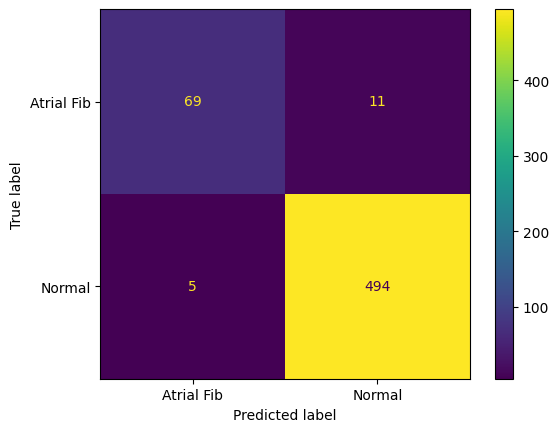


 SVC(class_weight={0: 738, 1: 5050})
              precision    recall  f1-score   support

  Atrial Fib       0.90      0.88      0.89        80
      Normal       0.98      0.98      0.98       499

    accuracy                           0.97       579
   macro avg       0.94      0.93      0.93       579
weighted avg       0.97      0.97      0.97       579



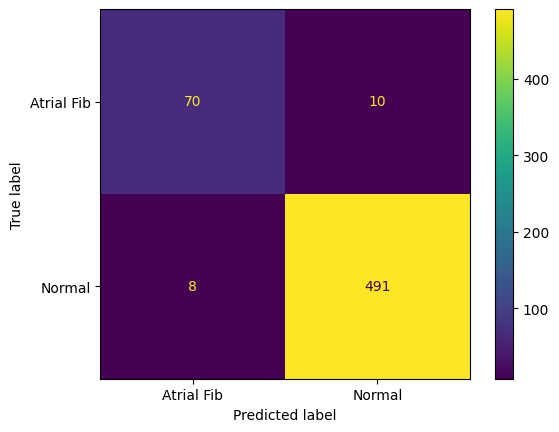


 SVC(kernel='linear')
              precision    recall  f1-score   support

  Atrial Fib       0.89      0.93      0.91        80
      Normal       0.99      0.98      0.98       499

    accuracy                           0.97       579
   macro avg       0.94      0.95      0.95       579
weighted avg       0.97      0.97      0.97       579



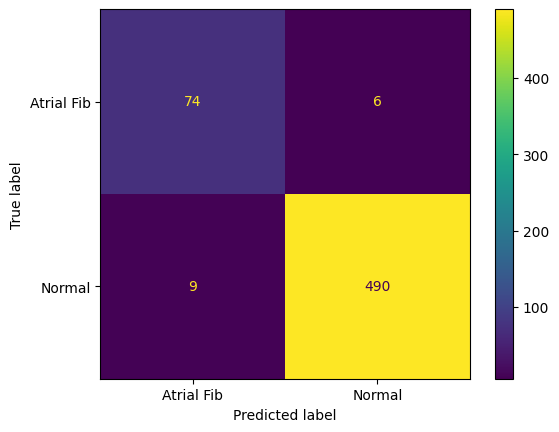

In [ ]:
# Classification of sex
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm
import warnings
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")

classifiers = [
     MLPClassifier(max_iter=100, early_stopping=True, learning_rate_init=0.001,
                   validation_fraction=0.05,
                   verbose=False, hidden_layer_sizes=(256, 512, 512, 256)),

    SVC(kernel="rbf",class_weight = {0:num_AF, 1:num_normal}),
    SVC(kernel="linear")#,class_weight = {0:num_AF, 1:num_normal})
    # SVC(kernel="poly",class_weight = {0:num_AF, 1:num_normal}),
    # GaussianNB(),
    # KNeighborsClassifier(3)
]

target_names1 = ["Atrial Fib", "Normal"]
#target_names2 = ["1","2","3","4"]
def eval(y_true, y_pred, clf=""):
    cr = classification_report(y_true, y_pred, target_names=target_names1)
    print(cr)
    data = parse_classification_report(str(cr))
    # print(report_to_latex_table(data))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names1)
    disp.plot()
    plt.savefig(f"cm_{clf}.pdf")
    plt.show()
    # plot_scatter(clf)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.1, random_state=10)




scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# save the scaler object
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


X_test = scaler.transform(X_test)
for clf in tqdm(classifiers):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print("\n", clf)
    eval(y_test, y_pred, clf)


# Saving Best Model (MLP)

In [ ]:
classifiers[2]

SVC(kernel='linear')

In [ ]:
import pickle

with open('svm_linear_model.pkl', 'wb') as f:
    pickle.dump(classifiers[2], f)

## Using Previously Saved Model


 MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 512, 512, 256),
              max_iter=100, validation_fraction=0.05)
              precision    recall  f1-score   support

  Atrial Fib       0.95      0.91      0.93        80
      Normal       0.99      0.99      0.99       499

    accuracy                           0.98       579
   macro avg       0.97      0.95      0.96       579
weighted avg       0.98      0.98      0.98       579



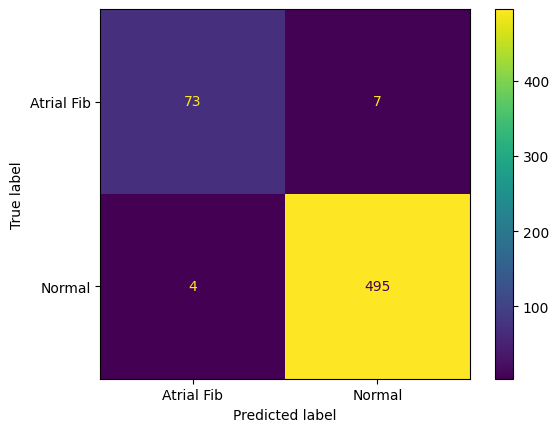

In [ ]:
import pickle

# load the saved model from disk using pickle.load()
with open('/content/drive/MyDrive/Trained_clf_ECG/mlp1_model.pkl', 'rb') as f:
    clf_mlp = pickle.load(f)

# use the loaded model for inference
y_pred = clf_mlp.predict(X_test)
print("\n", clf_mlp)
eval(y_test, y_pred, clf_mlp)